# Data analyst Nanodegree, Project 1

**Author:** Mat Leonard

Here, I'm going to analysis data from an experiment on the [Stroop effect](https://en.wikipedia.org/wiki/Stroop_effect). This is for my work on [Udacity's Data Analyst Nanodegree](https://www.udacity.com/course/data-analyst-nanodegree--nd002), Project 1: Test a Perceptual Phenomenon.

Now, import the data.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sb

In [2]:
df = pd.read_csv('stroopdata.csv')
df

,Congruent,Incongruent
0,12.079,19.278
1,16.791,18.741
2,9.564,21.214
3,8.630,15.687
4,14.669,22.803
5,12.238,20.878
6,14.692,24.572
7,8.987,17.394
8,9.401,20.762
9,14.480,26.282


The data is shown above. Pretty cool stuff. Here, our independent variable is the condition, congruent or incongruent words. The dependent variable is the performance time.

I'll create some histograms to view the distributions and then calculate some descriptive statistics.

## Looking at the distribution of performances

Now I'm going to look at the performance distributions to get a sense of the data. I'll make histograms of each group, plot them on the same figure.

In [5]:
sb.set_context('notebook', font_scale=1.25)

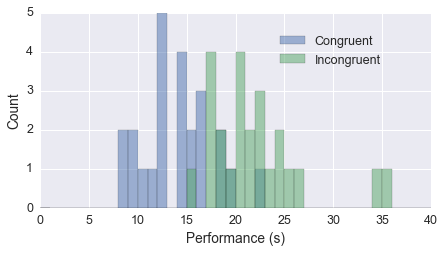

In [16]:
fig, ax = plt.subplots(figsize=(7,3.5))
#colors = {'Congruent':'steelblue', 'Incongruent':'orangered'}
for col in df:
    ax.hist(df[col], range=(0,40), bins=40, alpha=0.5)
ax.set_xlabel('Performance (s)')
ax.set_ylabel('Count')
ax.legend(loc=(0.6,0.7), frameon=False)

Looks like the subjects perform quicker for congruent words than for incongruent words. Next, I'll calculate the mean, standard deviation, and median for the performances.

In [5]:
df.describe().ix[['mean', 'std', '50%']]

,Congruent,Incongruent
mean,14.051125,22.015917
std,3.559358,4.797057
50%,14.356500,21.017500


The mean performance for the congruent words is roughly 6 seconds faster than for incongruent words. The standard deviation for congruent words is smaller too, but this difference is likely caused by the two incongruent outliers around 35 seconds.

## Is there a likely effect on performance between the conditions?

Now, I'll see if there is an effect on performance between the congruent and incongruent words. We see above that the performance on congruent words is quicker, but is this just a statistical fluke? I can perform a hypothesis test to estimate the likelihood that the means of the two distributions are the same. Here, our null hypothesis is that the mean performance for congruent and incongruent words is equal, $\mu_C = \mu_I$. The alternative hypothesis is that the means are different, $\mu_C \neq \mu_I$. The distributions for each group are roughly normal, so I can use a *t-test* to calculate a p-value.

In [11]:
tstat, p, dfree = sm.stats.ttest_ind(df['Congruent'], df['Incongruent'])
print("Two-tailed p-value: {:.3e}".format(p))

Two-tailed p-value: 4.595e-08


I'll do a bit more work and actually calculate the t-statistics myself, instead of using statsmodels. I'll calculate Welch's t-statistic. I'm copying these from [my blog post](http://matatat.org/p-values-statistical-testing.html) because I'm lazy.

In [12]:
def welch_t(a, b):
    """ Calculate the t statistic for two samples. """
    diff = a.mean() - b.mean()
    var = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    return diff/var

In [13]:
def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    s_a, s_b = a.var(ddof=1), b.var(ddof=1)
    n_a, n_b = a.size, b.size
    numer = (s_a/n_a + s_b/n_b)**2
    denom = (s_a/ n_a)**2/(n_a - 1) + (s_b/ n_b)**2/(n_b - 1)
    return numer/denom

Now calculate the t-statistic from the data.

In [14]:
t = welch_t(df['Congruent'], df['Incongruent'])
dfree = welch_df(df['Congruent'], df['Incongruent'])
print("t-statistic: {:.3f}, with degrees of freedom: {:.3f}".\
      format(t, dfree))

t-statistic: -6.532, with degrees of freedom: 42.434


And from the t-statistic, calculate the p-value. The data t-statistic is negative here, so the (one-sided) p-value is the probability that we would get a t-statistic less than $-6.532$ under the null hypothesis. I'll plot the t-distribution with degrees of freedom $42.434$, this is the distribution of t-statistics under the null hypothesis. I'll also include a dashed line indicating the data t-statistic.

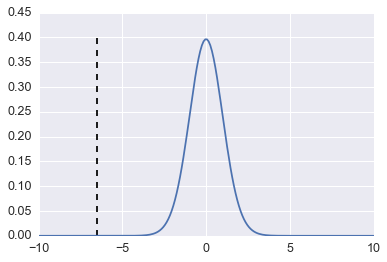

In [18]:
x = np.linspace(-10,10,num=200)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, sp.stats.t.pdf(x, loc=0, df=dfree))
ax.vlines(t, 0, ax.get_ylim()[1], linestyle='--')

The p-value can easily be calculated from the cumulative density function, in this case $ p = \mathrm{cdf}(t) $ for the one-sided p-value. To get the two-sided p-value, just multiply by 2.

In [19]:
p = sp.stats.t.cdf(t, df=dfree)*2
print("Two-tailed p-value: {:.3e}".format(p))

Two-tailed p-value: 6.510e-08


The p-value is well below $0.05$ here, so I should reject the null hypothesis. I conclude that performance on congruent words is likely faster than performance on incongruent words. This matches my intuition, because I can certainly feel myself reading the incongruent words slower.

I imagine this effect exists because our brains are better at reading words, something we do all the time, than naming colors. We have to inhibit our inclination to read the words and instead name the color, leading to longer processing times for the incongruent condition.